# Regression Modelling

Using regression models to predict house prices

The dataset consists of several features of houses sold in 2014-2015.

We will be doing some exploratory analysis of the data, some feature engineering to create useful features and also some preprocessing so we have can try out different models.

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Find list of tables in database
conn = sqlite3.connect('./data/home_sales.db')
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Load sales table as dataframe
df = pd.read_sql_query('SELECT * from sales', conn)

## Exploratory Data Analysis

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,review_score,basement_size,built,renovation,zipcode,latitude,longitude,living_room_size,lot_size
0,7787980.0,13 October 2014,221900.0,3.0,1.00,1.0,0.0,0.0,fair,10.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,6774848.0,09 December 2014,538000.0,3.0,2.25,2.0,0.0,0.0,fair,7.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,6999329.0,25 February 2015,180000.0,2.0,1.00,1.0,0.0,0.0,fair,8.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,7773052.0,09 December 2014,604000.0,4.0,3.00,1.0,0.0,0.0,excellent,6.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,7760818.0,18 February 2015,510000.0,3.0,2.00,1.0,0.0,0.0,fair,6.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


We see mostly numerical variables with some date and categorical variables.

Let's split out a test and training set before doing more analysis.

In [10]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18523 entries, 6781 to 15795
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                17493 non-null  float64
 1   date              17551 non-null  object 
 2   bedrooms          17526 non-null  float64
 3   bathrooms         17536 non-null  float64
 4   floors            17491 non-null  float64
 5   waterfront        17503 non-null  float64
 6   view              17529 non-null  float64
 7   condition         17518 non-null  object 
 8   review_score      17488 non-null  float64
 9   basement_size     17537 non-null  float64
 10  built             17469 non-null  float64
 11  renovation        17521 non-null  float64
 12  zipcode           17508 non-null  float64
 13  latitude          17527 non-null  float64
 14  longitude         17512 non-null  float64
 15  living_room_size  17514 non-null  float64
 16  lot_size          17556 non-null  flo

The inconsistent row values suggest that there are missing values and they are in pretty much every column

In [106]:
train.isnull().sum()

id                  1030
date                 972
bedrooms             997
bathrooms            987
floors              1032
waterfront          1020
view                 994
condition           1005
review_score        1035
basement_size        986
built               1054
renovation          1002
zipcode             1015
latitude             996
longitude           1011
living_room_size    1009
lot_size             967
price               1013
dtype: int64

In [107]:
train.dtypes[train.dtypes != "object"].index

Index(['id', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'review_score', 'basement_size', 'built', 'renovation', 'zipcode',
       'latitude', 'longitude', 'living_room_size', 'lot_size', 'price'],
      dtype='object')

In [6]:
num_vars = ['price', 'bedrooms', 'bathrooms', 'floors', 'view', 'review_score', 'basement_size', 'built', 'renovation', 'living_room_size', 'lot_size']
cat_vars = ['waterfront', 'date', 'latitude', 'longitude', 'zipcode', 'condition']

Let's have a look a the distributions of the numerical variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189C3D576A0>,
      dtype=object)

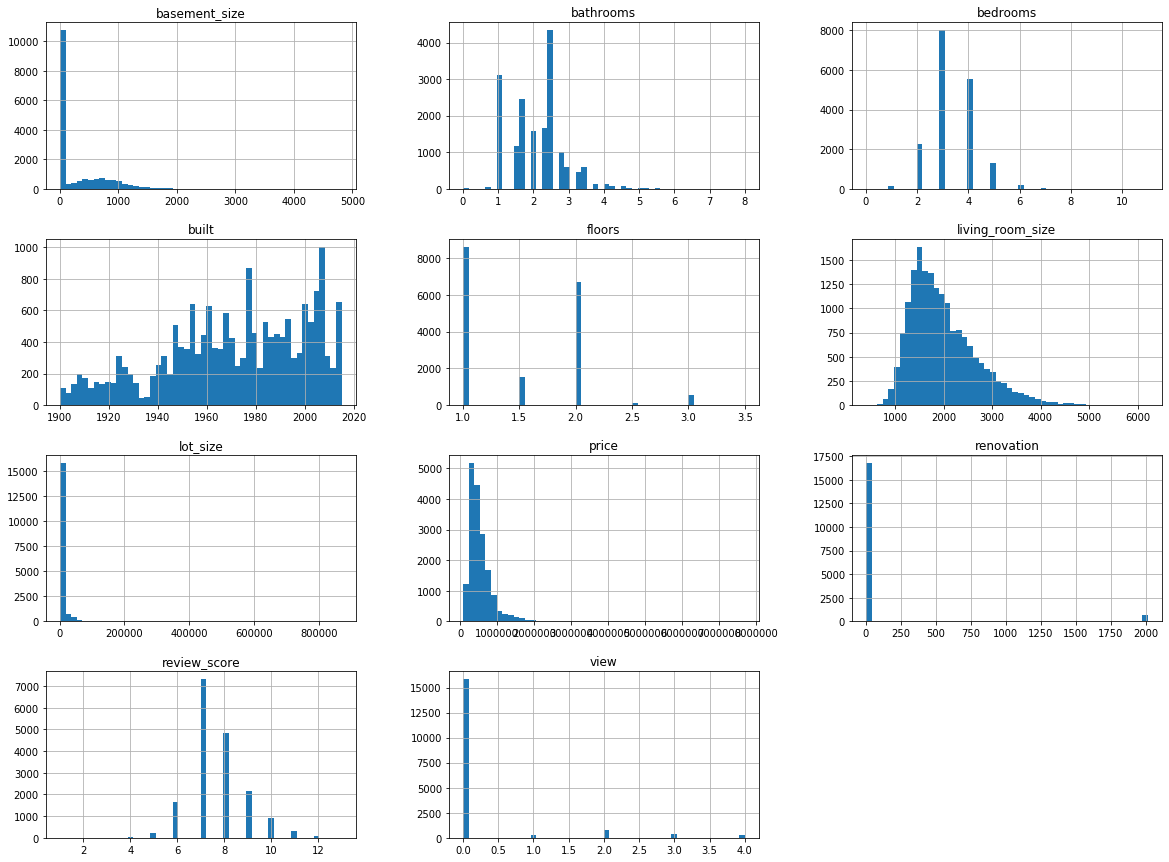

In [10]:
train[num_vars].hist(bins=50, figsize=(20,15))

Couple of observations:
- `Price`, `lot_size` and `living room size` seem to be power law distributed
- `lot size`, `renovation` and `basement size` contain a lot of 0 values so might not be useful features

In [11]:
corr_matrix = train[num_vars].corr()

corr_matrix['price'].sort_values(ascending=False)

price               1.000000
living_room_size    0.585989
bathrooms           0.532713
view                0.406355
basement_size       0.327795
bedrooms            0.317546
floors              0.255440
renovation          0.130068
lot_size            0.086534
built               0.058505
review_score        0.001758
Name: price, dtype: float64

We can see `living_room_size`, `bathrooms` and `view` has pretty good correlation with `price`

Since correlation scores only reflect linear relationships, we will also do a scatterplot between the variables. We will select the variables with the most correlation score for this.

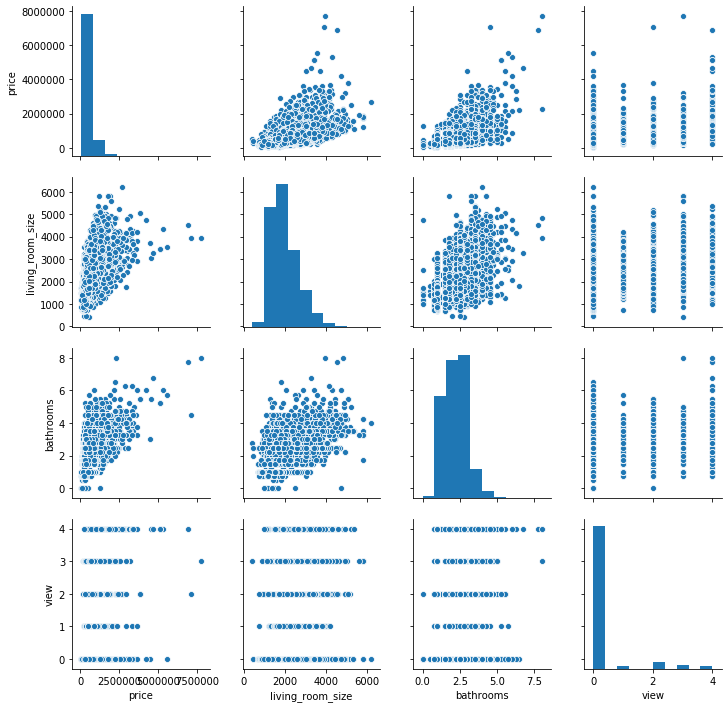

In [39]:
sns.pairplot(train[num_vars].dropna(), vars = ['price', 'living_room_size', 'bathrooms', 'view'])

We see that there could be some collinearity between `bathrooms` and `living_room_size`

Now let's look at the categorical variables.

In [13]:
train['condition'].unique()

array(['good', 'fair', 'FAIR', None, 'GOOD', 'EXCELLENT', 'excellent',
       'terrible', 'poor', 'POOR', 'TERRIBLE'], dtype=object)

In [14]:
# clean up the labels in condition
train['condition'] = train['condition'].str.lower()

In [15]:
train['condition'].unique()

array(['good', 'fair', None, 'excellent', 'terrible', 'poor'],
      dtype=object)

Text(0.5, 1.0, 'Price categorized by Condition')

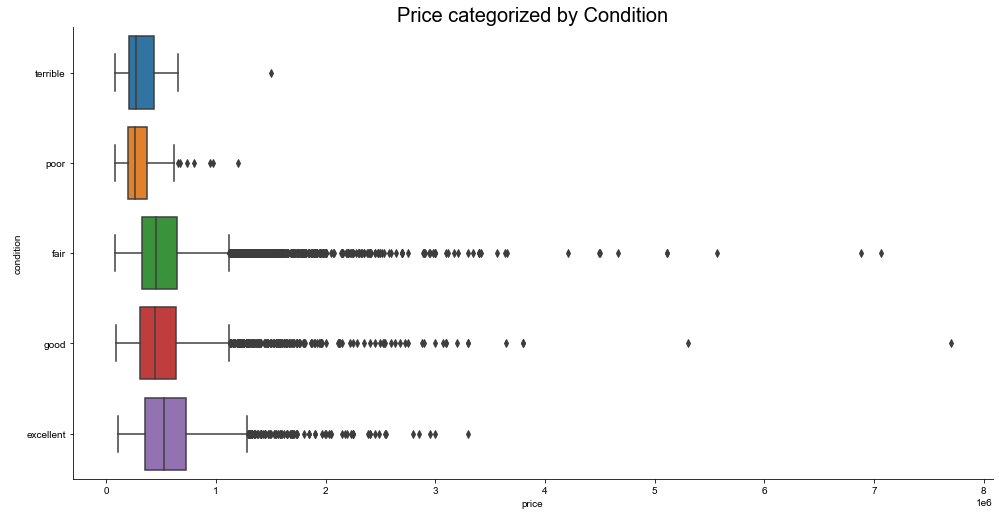

In [16]:
sns.catplot(y='condition', x='price', kind='box', data=train, height=7, aspect=2,\
           order = ['terrible', 'poor', 'fair', 'good', 'excellent'])
sns.set(font_scale=1.5)
plt.title('Price categorized by Condition', fontsize=20)

Text(0.5, 1.0, 'Frequency of Condition Labels')

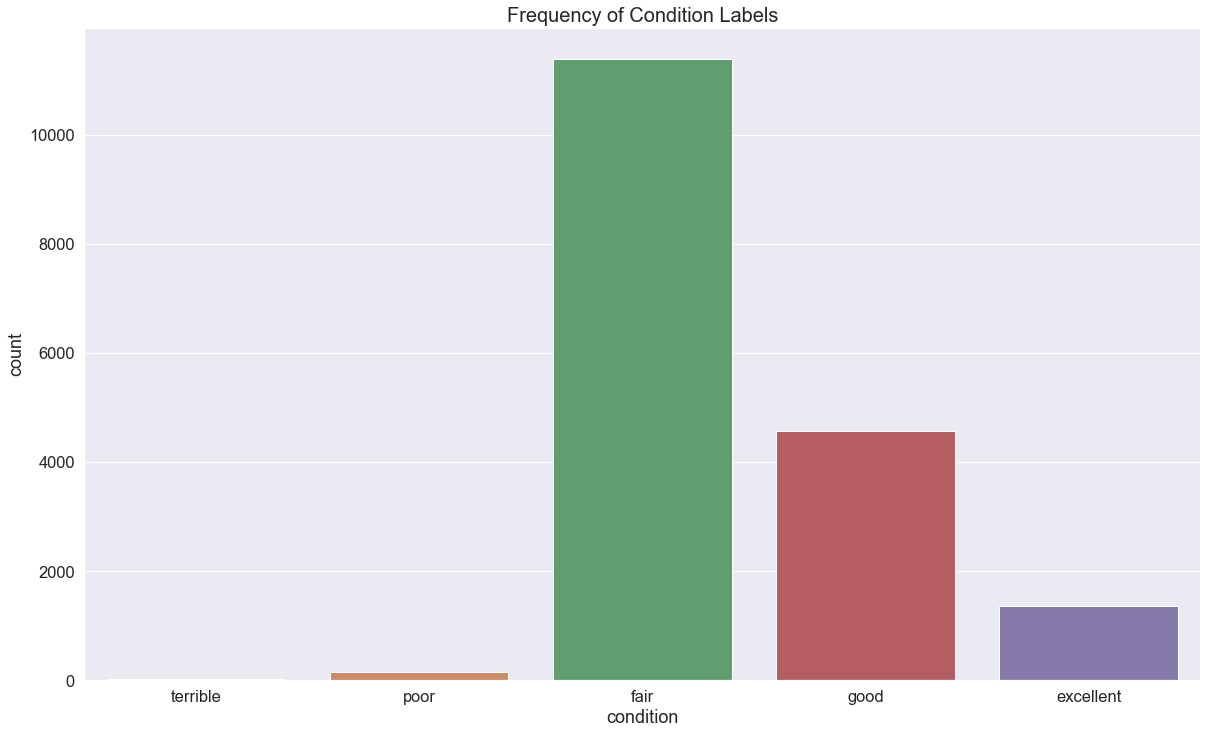

In [36]:
plt.figure(figsize=(20,12))
sns.set(font_scale=1.5)
sns.countplot(x='condition', data=train,\
              order = ['terrible', 'poor', 'fair', 'good', 'excellent'])
plt.title('Frequency of Condition Labels', fontsize=20)

We can see that there is some correlation with price as conditions improve

In terms of distribution of the labels, majority of them are better than 'fair condition'

In [ ]:
sns.catplot(x='waterfront', y='price', kind='box', data=train, height=7, aspect=1)
sns.set(font_scale=1.5)
plt.title('Price categorized by Waterfront', fontsize=20)

Text(0.5, 1.0, 'Frequency of Waterfront Labels')

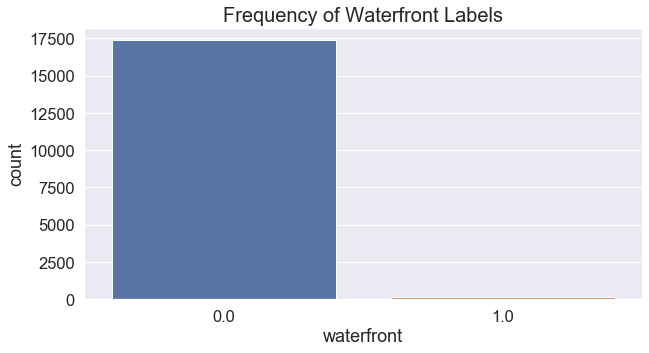

In [22]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.countplot(x='waterfront', data=train)
plt.title('Frequency of Waterfront Labels', fontsize=20)

We can see that there is a correlation with higher prices and the presence of a waterfront but looking at the frequency, it seems only applicable to a very small handful of cases.

There are some misspelled months that we need to clean up before converting them into datetime format

In [17]:
def correct_month(x):
    if x is None:
        return x
    else:
        return month_checker(x)
    
def month_checker(date):
    for month in ['Apil', 'Apri', 'Aprl',  'pril']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' April ' + str(date).split()[2]
    
    for month in ['Augst', 'Augus', 'Augut', 'Auust', 'ugust']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' August ' + str(date).split()[2]
    
    for month in ['Dcember', 'Deceber', 'Decembr', 'Decmber', 'ecember']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' December ' + str(date).split()[2]
    
    for month in ['Febuary', 'Feburary', 'Feruary', 'ebruary']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' February ' + str(date).split()[2]
    
    for month in  ['Januar','Janury', 'Jauary', 'Jnuary']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' January ' + str(date).split()[2]
    
    for month in  ['Jly', 'Jul', 'Juy', 'uly']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' July ' + str(date).split()[2]
    
    for month in  ['Jne', 'Jue', 'Jun', 'une']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' June ' + str(date).split()[2]
    
    for month in  ['Marc', 'Marh', 'Mrch', 'arch']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' March ' + str(date).split()[2]
    
    for month in  ['Ma', 'My', 'ay']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' May ' + str(date).split()[2]
        
    for month in  ['Noember', 'ovember', 'Novembr', 'Novemer']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' November ' + str(date).split()[2]
    
    for month in  ['Octobe', 'Octobr']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' October ' + str(date).split()[2]
        
    for month in  ['Sepember', 'Septeber', 'Septemer', 'Setember', 'Sptember', 'eptember']:
        if str(date).split()[1] == month:
            return str(date).split()[0] + ' September ' + str(date).split()[2]
        
    return date

train['date'] = train['date'].apply(correct_month)

# convert to datetime format
train['date'] = pd.to_datetime(train['date'], format='%d %B %Y', errors='ignore')

# here we convert the date variables to year-month
train['month-year'] = pd.to_datetime(train['date']).dt.to_period('M')

# also created a ordinal date column
train['ordinal_date'] = train['date'].apply(lambda x : x.toordinal() if pd.notna(x) else None)

In [18]:
# do the same for test data
test['date'] = test['date'].apply(correct_month)

# convert to datetime format
test['date'] = pd.to_datetime(test['date'], format='%d %B %Y', errors='ignore')

# here we convert the date variables to year-month
test['month-year'] = pd.to_datetime(test['date']).dt.to_period('M')

# also created a ordinal date column
test['ordinal_date'] = test['date'].apply(lambda x : x.toordinal() if pd.notna(x) else None)

Text(0.5, 1.0, 'Price vs Year-Month')

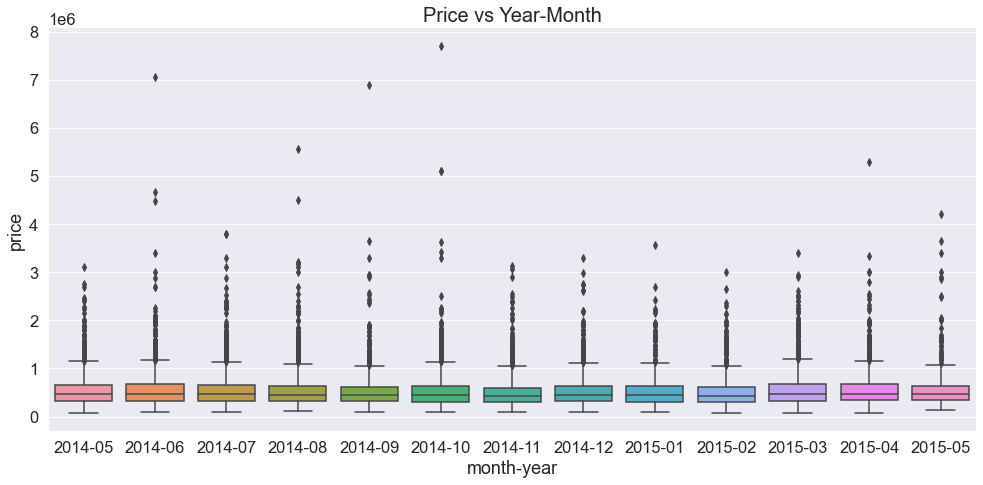

In [19]:
sns.catplot(x='month-year', y='price', kind='box', data=train, height=7, aspect=2, order=sorted(train['month-year'].unique()[:-1]))
sns.set(font_scale=1.5)
plt.title('Price vs Year-Month', fontsize=20)

There doesn't seem to be much correlation between `month-year` and the `price`

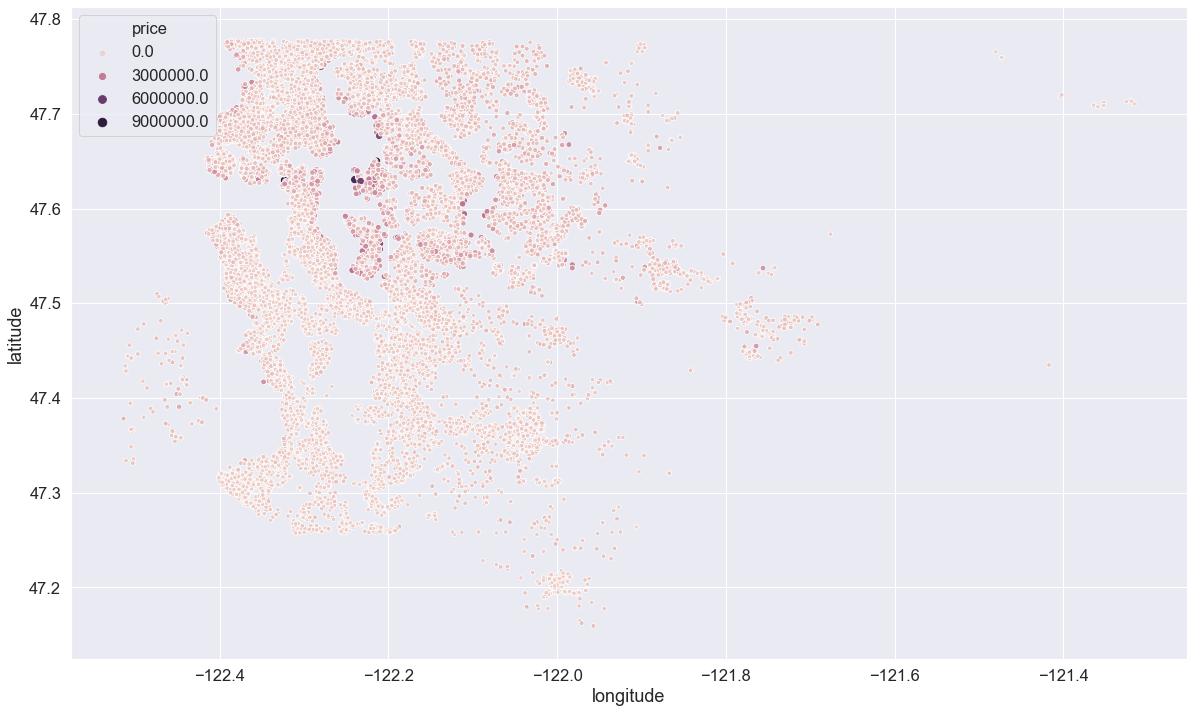

In [159]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20,12))
sns.scatterplot(x='longitude', y='latitude', hue='price', size='price', data=train)

We can see the higher prices are found in certain locations, particularly areas near the coastline. There are also 2 major dots that indicate the highest prices are found on the coast.

## Preprocessing

Now that we've explored the data and have some insights on how they are shaped, it's time for some preprocessing. Here's what we need to do from what we've learnt:
0. Remove all NAs
1. Log transform `living_room_size`, `lot_size`
2. Standardize all numeric vars
3. Encode `condition`
3. Drop `waterfront`, `zipcode`, `latitude`, `longitude`, `month-year`, `date`

In [20]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'review_score', 'basement_size', 'built', 'renovation',
       'zipcode', 'latitude', 'longitude', 'living_room_size', 'lot_size',
       'price', 'month-year', 'ordinal_date'],
      dtype='object')

In [21]:
train.dropna(inplace=True)
train.drop(['id','waterfront', 'zipcode', 'latitude', 'longitude', 'date', 'month-year'],\
          axis=1, inplace=True)

In [22]:
test.dropna(inplace=True)
test.drop(['id','waterfront', 'zipcode', 'latitude', 'longitude', 'date', 'month-year'],\
          axis=1, inplace=True)

In [23]:
# map ordinal features in 'condition'

mapper = {'terrible':0, 'poor':1, 'fair':2, 'good':3, 'excellent':4}

train['condition'] = train.condition.map(mapper)

test['condition'] = test['condition'].str.lower()
test['condition'] = test.condition.map(mapper)

In [27]:
# check missing values
test.isnull().sum()

bedrooms            0
bathrooms           0
floors              0
view                0
condition           0
review_score        0
basement_size       0
built               0
renovation          0
living_room_size    0
lot_size            0
price               0
month-year          0
ordinal_date        0
dtype: int64

In [25]:
y_train = train['price']
X_train = train.drop('price', axis=1)

In [26]:
y_test = test['price']
X_test = test.drop('price', axis=1)

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

In [31]:
num_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]

In [40]:
#log transform living room size and lot size
X_train[['living_room_size', 'lot_size']] = np.log1p(X_train[['living_room_size', 'lot_size']])
X_test[['living_room_size', 'lot_size']] = np.log1p(X_test[['living_room_size', 'lot_size']])

#scale numeric features
ct = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols)
])

X_train[num_cols] = ct.fit_transform(X_train)
X_test[num_cols] = ct.fit_transform(X_test)

## Modelling

In [47]:
# evaluating a few models

from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR

regressors = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    ElasticNet(alpha=1)
]

# using transformed target regressor
tt_regressors = [TransformedTargetRegressor(regressor=regressor,
                                           func=np.log1p, inverse_func= np.expm1) for regressor in regressors]

for regressor in tt_regressors:    
    score = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'Mean score for {regressor} is {np.sqrt(-score.mean())}')


Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression()) is 247485.9644112221
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=DecisionTreeRegressor(random_state=42)) is 314504.18051090953
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(random_state=42)) is 225396.79802888705
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=ElasticNet(alpha=0.8)) is 379639.4301777802


In [55]:
# without using transformed target regressors
for regressor in regressors:    
    score = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'Mean score for {regressor} is {np.sqrt(-score.mean())}')

Mean score for LinearRegression() is 263023.5756252223
Mean score for DecisionTreeRegressor(random_state=42) is 311631.2820445933
Mean score for RandomForestRegressor(random_state=42) is 219085.79546516243
Mean score for ElasticNet(alpha=0.8) is 270319.52222875477


In [58]:
# introduce polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

for regressor in tt_regressors:    
    score = cross_val_score(regressor, poly.fit_transform(X_train), y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'Mean score for {regressor} is {np.sqrt(-score.mean())}')

Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression()) is 260336.18274671288
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=DecisionTreeRegressor(random_state=42)) is 314776.1518623141
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(random_state=42)) is 227368.47220813786
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=ElasticNet(alpha=0.8)) is 367482.90460363287


In [61]:
# trying another way to add polynomials
X_train_poly = X_train.copy()
X_test_poly = X_test.copy()

for col in num_cols:
    X_train_poly[col+'_2'] = X_train[col] * X_train[col]
    X_test_poly[col+'_2'] = X_test[col] * X_test[col]

In [63]:
# training on poly features
for regressor in tt_regressors:    
    score = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'Mean score for {regressor} is {np.sqrt(-score.mean())}')

Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=LinearRegression()) is 247485.9644112221
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=DecisionTreeRegressor(random_state=42)) is 314504.18051090953
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(random_state=42)) is 225396.79802888705
Mean score for TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=ElasticNet(alpha=0.8)) is 379639.4301777802


In [64]:
# polynomial features without using transformed target regressors
for regressor in regressors:    
    score = cross_val_score(regressor, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f'Mean score for {regressor} is {np.sqrt(-score.mean())}')

Mean score for LinearRegression() is 239715.67241704196
Mean score for DecisionTreeRegressor(random_state=42) is 316853.33304252574
Mean score for RandomForestRegressor(random_state=42) is 220791.8044755984
Mean score for ElasticNet(alpha=0.8) is 245296.0561198086


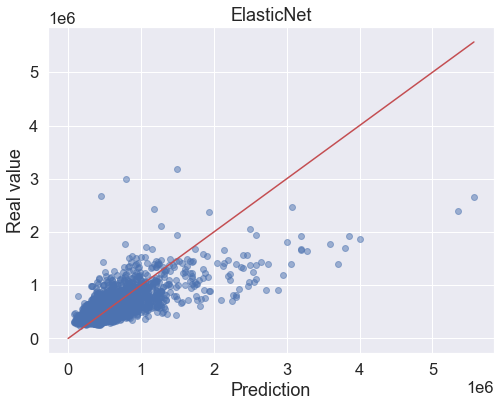

In [78]:
def regression_plot(y_true, y_pred, name):
    """
    Draws scatterplot of predicted values against actual values
    """
    pd.plotting.register_matplotlib_converters()
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, cmap='plasma', alpha=0.5)
    plt.xlabel('Prediction')
    plt.ylabel('Real value')
    plt.title(name)
    diagonal = np.linspace(0, np.max(y_true), 100)
    plt.plot(diagonal, diagonal, '-r')
    plt.show()
    
enet = ElasticNet(alpha=0.80)
enet.fit(X_train_poly, y_train)
enet_y_pred = enet.predict(X_test_poly)

regression_plot(y_test, enet_y_pred, name='ElasticNet')

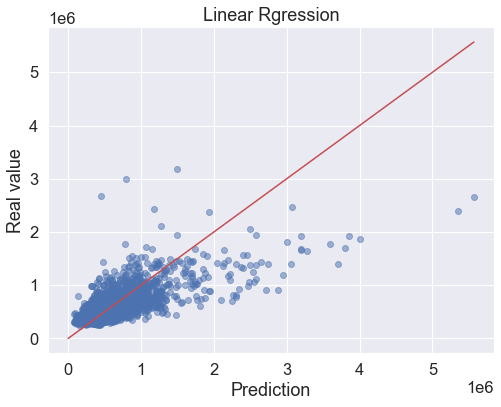

In [79]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)
lr_y_pred = enet.predict(X_test_poly)

regression_plot(y_test, lr_y_pred, name='Linear Rgression')

In [76]:
X_test_poly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3928 entries, 7007 to 10544
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            3928 non-null   float64
 1   bathrooms           3928 non-null   float64
 2   floors              3928 non-null   float64
 3   view                3928 non-null   float64
 4   condition           3928 non-null   float64
 5   review_score        3928 non-null   float64
 6   basement_size       3928 non-null   float64
 7   built               3928 non-null   float64
 8   renovation          3928 non-null   float64
 9   living_room_size    3928 non-null   float64
 10  lot_size            3928 non-null   float64
 11  ordinal_date        3928 non-null   float64
 12  bedrooms_2          3928 non-null   float64
 13  bathrooms_2         3928 non-null   float64
 14  floors_2            3928 non-null   float64
 15  view_2              3928 non-null   float64
 16  co

So we tried a couple of things above:
- Using TransformedTargetRegressor to transform the target variable during training
- Adding degree=2 polynomial features for numerical features

We learnt that using the TransformedTarget seems to do worse for the Linear Regression model, slightly better for our tree-based models and much better for ElasticNet(alpha=1.0) which is basically a LASSO regression.

Adding polynomials improved the score for both Linear Regression and ElasticNet but not so much for the tree-based methods

Out of the 4 models we tried, the one with the least RMSE (220791.80) is Random Forest but it also took the longest. A close second is good old LinearRegression with much less training time and interpretability. Next up we will tune the hyperparamters to see if we can achieve a better RMSE.

## Hyperparams Tuning

In [65]:
from sklearn.model_selection import GridSearchCV

en_parameters = {'alpha': [0.2, 0.4, 0.6, 0.8, 1.0]}

en = ElasticNet()

elastic_reg = GridSearchCV(en, en_parameters, scoring='neg_mean_squared_error')
elastic_reg.fit(X_train_poly, y_train)

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0.2, 0.4, 0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [66]:
print('RMSE for ElasticNet GridSearchCV')
means = elastic_reg.cv_results_['mean_test_score']
stds = elastic_reg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, elastic_reg.cv_results_['params']):
    print("%0.3f for %r"
          % (np.sqrt(-mean), params))

RMSE for ElasticNet GridSearchCV
240839.940 for {'alpha': 0.2}
242253.974 for {'alpha': 0.4}
243774.829 for {'alpha': 0.6}
245296.056 for {'alpha': 0.8}
246785.213 for {'alpha': 1.0}


Out of the 4 models earlier, the one with the most potential for tuning is ElasticNet since the tree-based methods are omitted due to their poor interpretability and longer training time. From the GridSearchCV results, we can see that using alpha of 0.2 gave the best (lowest) score. 

## Next Steps

-  There are still some features that we haven't made of use of yet, like `zipcode`, `lattitude` and `longitude` so I will be exploring ways we can use them to enhance our model accuracy.